In [1]:
import qctoolkit as qtk
import numpy as np
import glob
import copy
import os
import re
import matplotlib.pyplot as plt
from base import * # for cyl_map
from matplotlib import gridspec

#plt.style.use('ggplot')
#plt.style.use('seaborn-bright')
plt.style.use('classic')

%matplotlib inline

# Load data

In [2]:
ref_all_Eg = qtk.pload('ref_bnd.pkl')
ref_all_DOS = qtk.pload('ref_dos.pkl')
prd_all_Eg = qtk.pload('prd_bnd.pkl')
prd_all_DOS = qtk.pload('prd_dos.pkl')

In [3]:
# load cube files
q_all = []
for q in sorted(glob.glob('cube/*.cube')):
    q_all.append(qtk.CUBE(q))

# Function definition

In [4]:
def get(sys, rsys=None, asys=None, get_cube=False):
    # something wrong with ref, prd comparison 
    if not asys:
        asys = sys
    q = sys + '_a-' + asys
    ref_name = [out.name.replace('.out', '') for out in ref_all_Eg]
    try:
        ref_Eg = ref_all_Eg[ref_name.index(q)]
        ref_DOS = ref_all_DOS[ref_name.index(q)]
    except:
        print "%s not found" % q
        ref_Eg = None
        ref_DOS = None
    if rsys:
        prd_q = sys + '_r-' + rsys + '_a-' + asys
        prd_Eg_name = [out.name.replace('.out', '') for out in prd_all_Eg]
        prd_DOS_name = [out.name.replace('.out', '') for out in prd_all_DOS]
        try:
            prd_Eg = prd_all_Eg[prd_Eg_name.index(prd_q)]
            prd_DOS = prd_all_DOS[prd_DOS_name.index(prd_q)]
        except:
            print "%s not found" % prd_q
            prd_Eg = None
            prd_DOS = None
    else:
        prd_Eg = None
        prd_DOS = None
    if not get_cube:
        return ref_Eg, ref_DOS, prd_Eg, prd_DOS
    
    else:
        tar_q = sys + '_a-' + asys + '.cube'
        ref_q = rsys + '_a-' + asys + '.cube'
        q_name = [q.name for q in q_all]
        q_tar = q_all[q_name.index(tar_q)]
        q_ref = q_all[q_name.index(ref_q)]
        return ref_Eg, ref_DOS, prd_Eg, prd_DOS, q_ref, q_tar

In [5]:
a, _, b, _ = copy.deepcopy(get('alas', 'gaas'))
c, _, d, _ = copy.deepcopy(get('gaas', 'alas'))
for out in [a,b,c,d]:
    out.band = out.band - np.max(out.band[:, 3])
#     plt.plot(out.band[:, 3])
#     plt.plot(out.band[:, 4])
def getDEg(out):
    return np.min((out.band[out.band > 0.4]))

print getDEg(a) - getDEg(b), getDEg(c) - getDEg(d)
print abs(a.band - b.band).mean(), abs(c.band - d.band).mean()

-0.247895818763 -0.170887567709
0.250024996176 0.121614646497


In [6]:
def _shift_band(out):
    band = out.band.copy()
    occ = out.molecule.getValenceElectrons()/2
    e_fermi = np.max(band[:, occ - 1])
    out.band = out.band - e_fermi
    return out
    

def plot_band(out_eg_in, out_dos_in, 
              prd_eg_in=None, prd_dos_in=None,
              ref_eg_in=None, ref_dos_in=None,
              sigma=0.15, title=False, 
              shift_fermi=True, save_path = None,
              ax1 = None, ax2 = None,
              return_band = False,
              true_label = '',
              ref_label = '',
              prd_label = '',
              prd_color = 'b',
             ):
    
    out_eg = copy.deepcopy(out_eg_in)
    out_dos = copy.deepcopy(out_dos_in)
    prd_eg = copy.deepcopy(prd_eg_in)
    prd_dos = copy.deepcopy(prd_dos_in)
    ref_eg = copy.deepcopy(ref_eg_in)
    ref_dos = copy.deepcopy(ref_dos_in)
    
    if shift_fermi:
        out_eg = _shift_band(out_eg)
        out_dos = _shift_band(out_dos)
    band = out_eg.band
    dos = out_dos.DOS(sigma)
    occ = out_eg.molecule.getValenceElectrons()/2
    
    b_max, b_min = np.max(band), np.min(band)
    p_max = b_max + 0.1 * (b_max - b_min)
    p_min = b_min - 0.1 * (b_max - b_min)
    
    plt_prd = False
    if prd_eg is not None:
        plt_prd = True
        if shift_fermi:
            prd_eg = _shift_band(prd_eg)
            prd_dos = _shift_band(prd_dos)
        band_prd = prd_eg.band.copy()
        dos_prd = prd_dos.DOS(sigma)
        
    plt_ref = False
    if ref_eg is not None:
        plt_ref = True
        if shift_fermi:
            ref_eg = _shift_band(ref_eg)
            ref_dos = _shift_band(ref_dos)
        band_ref = ref_eg.band.copy()
        dos_ref = ref_dos.DOS(sigma)
        
    if ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6), sharey=True)
    if title:
        if prd_eg:
            _tar, _ref = prd_eg.name.split('_a')[0].split('_r-')
            ax1.set_title(_tar + ' from ' + _ref)
        else:
            ax1.set_title(out_eg.name)
    ax1.plot(band[:, :1], color='k', label=true_label)
    ax1.plot(band[:, 1:], color='k')
    ax1.set_xlim([0, 67])
    ax1.set_ylim([p_min, p_max])
    if plt_prd:
        ax1.plot(band_prd[:, :1], '--', color=prd_color, label=prd_label)
        ax1.plot(band_prd[:, 1:], '--', color=prd_color)
    if plt_ref:
        ax1.plot(band_ref[:, :1], color='0.2', ls=':', label=ref_label)
        ax1.plot(band_ref[:, 1:], color='0.2', ls=':')
    
    ax2.plot(dos[:,1], dos[:,0], color='k')
    xmin, xmax = ax2.get_xlim()
    ax2.fill_betweenx(dos[:,0], dos[:,1],0, where=dos[:,0] < 0, facecolor='gray')
    ax2.set_ylim([p_min, p_max])
    ax2.set_xlim([max(xmin, 0), xmax])
    if plt_prd:
        ax2.plot(dos_prd[:,1], dos_prd[:,0], 'b--')
    if plt_ref:
        ax2.plot(dos_ref[:,1], dos_ref[:,0], color='0.2', ls=':')
        
    if save_path and os.path.exists(save_path) and prd_eg_in:
        fig_name = prd_eg_in.name.replace('.out', '')
        plt.savefig(save_path + '/' + fig_name + '.png')
    
    if return_band:
        return ax1, ax2, band_ref, band_prd 
    else:
        return ax1, ax2

(<matplotlib.axes._subplots.AxesSubplot at 0x2b9305c5d0d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b92c7514390>)

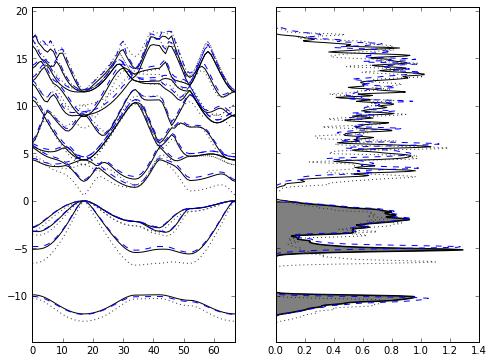

In [7]:
tru_Eg, tru_DOS, prd_Eg, prd_DOS = get('alas', rsys='gaas', asys='gaas')
ref_Eg, ref_DOS, _, _ = get('gaas', rsys='gaas', asys='gaas')
#plot_band(ref_Eg, ref_DOS)
#plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS)
plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS)

In [8]:
def sys_plot(sys, rsys, asys, **kwargs):
    if 'show_ref' in kwargs and kwargs['show_ref']:
        del kwargs['show_ref']
        tru_Eg, tru_DOS, prd_Eg, prd_DOS = get(sys, rsys=rsys, asys=asys)
        ref_Eg, ref_DOS, _, _ = get(rsys, rsys=rsys, asys=asys)
        ax = list(plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS, title=True, **kwargs))
    else:
        tru_Eg, tru_DOS, prd_Eg, prd_DOS = get(sys, rsys=rsys, asys=asys)
        ax = list(plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, title=True, **kwargs))
    return ax, [tru_Eg, tru_DOS, prd_Eg, prd_DOS]
    
def a_cyl_list(sys, rsys):
    base = ['si', 'gaas', 'cdse']
    grp_sys = ''
    grp_ref = ''
    for b in base:
        if sys in [info[0] for info in cyl_map[b]]:
            grp_sys = b
            a0_list = [info[1] for info in cyl_map[b]]
            cyl_list = [info[0] for info in cyl_map[b]]
        if rsys in [info[0] for info in cyl_map[b]]:
            grp_ref = b
    if grp_ref == grp_sys:
        ind = np.argsort(a0_list)
        a0_list = np.array(a0_list)[ind].tolist()
        cyl_list = np.array(cyl_list)[ind].tolist()
        return cyl_list, a0_list
    else:
        return [], []
    
def a_plot(sys, rsys, scan=True, **kwargs):
    cyl_list, a0_list = a_cyl_list(sys, rsys)
    if cyl_list:
        ax_list = []
        
        for cyl in cyl_list:
            if scan:
                ax_list.append(sys_plot(sys, rsys, cyl, **kwargs))
            else:
                if cyl == sys:
                    ax_list.append(sys_plot(sys, rsys, cyl, **kwargs))
        return ax_list
    else:
        return None

In [9]:
def get_group(sys):
    for grp in cyl_map.keys():
        if sys in [info[0] for info in cyl_map[grp]]:
            return grp

# Analysis quantities

In [10]:
cyl_grp = []
for elem_grp in elements[:-1]:
    cyl_list = []
    for elem1 in elem_grp[0]:
        for elem2 in elem_grp[1]:
            if elem1 != elem2:
                if 'si' in elem1 and 'sn' in elem2:
                    cyl = elem2 + elem1
                elif 'ge' in elem1 and 'si' in elem2:
                    cyl = elem2 + elem1
                else:
                    cyl = elem1 + elem2
            else:
                cyl = elem1
            if cyl not in cyl_list and cyl != 'snge':
                cyl_list.append(cyl)
    cyl_grp.append(cyl_list)

In [11]:
y_maes_list = []
x_a0_list = []
label_path_list = []
q_diff_grp = []
for grp in cyl_grp:
    for sys in grp:
        for rsys in grp:
            if sys != rsys:
                cyl_list, a0_list = a_cyl_list(sys, rsys)
                maes = []
                q_diff_list = []
                for i in range(len(cyl_list)):
                    asys = cyl_list[i]
                    ref_Eg, ref_DOS, prd_Eg, prd_DOS, q_ref, q_tar = get(sys, rsys, asys, get_cube=True)
                    err = abs(ref_DOS.band - prd_DOS.band).T
                    maes.append((err * prd_DOS.kpoints[:, -1]).sum() / prd_DOS.band.shape[1])
                    q_diff_list.append((q_ref - q_tar).integrate(power=0))
                q_diff_grp.append(q_diff_list)
                y_maes_list.append(maes)
                x_a0_list.append(a0_list)
                label_path_list.append(sys + '_r-' + rsys)

In [12]:
y_maes_IV_IV = []
y_maes_III_V = []
q_diff_IV_IV = []
q_diff_III_V = []
for i in range(len(label_path_list)):
    sys = label_path_list[i]
    if 'si' in sys:
        y_maes_IV_IV.append(y_maes_list[i])
        q_diff_IV_IV.append(q_diff_grp[i])
    else:
        y_maes_III_V.append(y_maes_list[i])
        q_diff_III_V.append(q_diff_grp[i])

In [13]:
y_ptp = []
y_min = []
y_mean = []
q_mean = []
q_ptp = []
for i in range(len(y_maes_list)):
    y = y_maes_list[i]
    y_ptp.append(np.ptp(y))
    y_min.append(min(y))
    y_mean.append(np.mean(y))
    q = q_diff_grp[i]
    q_mean.append(np.mean(q))
    q_ptp.append(np.ptp(q))

In [14]:
y_maes_IV_IV_mean = []
q_diff_IV_IV_mean = []
y_maes_IV_IV_ptp = []
q_diff_IV_IV_ptp = []
for i in range(len(y_maes_IV_IV)):
    y = y_maes_IV_IV[i]
    y_maes_IV_IV_mean.append(np.mean(y))
    y_maes_IV_IV_ptp.append(np.ptp(y))
    q = q_diff_IV_IV[i]
    q_diff_IV_IV_mean.append(np.mean(q))
    q_diff_IV_IV_ptp.append(np.ptp(q))

y_maes_III_V_mean = []
q_diff_III_V_mean = []
y_maes_III_V_ptp = []
q_diff_III_V_ptp = []
for i in range(len(y_maes_III_V)):
    y = y_maes_III_V[i]
    y_maes_III_V_mean.append(np.mean(y))
    y_maes_III_V_ptp.append(np.ptp(y))
    q = q_diff_III_V[i]
    q_diff_III_V_mean.append(np.mean(q))
    q_diff_III_V_ptp.append(np.ptp(q))

In [15]:
_y_mean_good = []
good_list = []
good_list_q = []
for i in range(len(q_mean)):
    if q_mean[i] < 0.5:
        _y_mean_good.append(y_mean[i])
        good_list.append(label_path_list[i])
        good_list_q.append(q_mean[i])

In [16]:
Eg_ref_list = []
Eg_prd_list = []
Eg_ref_IV_IV = []
Eg_ref_III_V = []
Eg_prd_IV_IV = []
Eg_prd_III_V = []

for path in good_list:
    sys, rsys = path.split('_r-')
    cyl_list, a0_list = a_cyl_list(sys, rsys)
    Eg_ref = []
    Eg_prd = []
    for asys in cyl_list:
        ref_Eg, ref_DOS, prd_Eg, prd_DOS = get(sys, rsys, asys)
        occ = ref_Eg.molecule.getValenceElectrons()/2
        Eg_ref.append(min(ref_Eg.band[:, occ]) - max(ref_Eg.band[:,occ-1]))
        Eg_prd.append(min(prd_Eg.band[:, occ]) - max(prd_Eg.band[:,occ-1]))
    Eg_ref_list.append(Eg_ref)
    Eg_prd_list.append(Eg_prd)
    
    if sys == 'si':
        Eg_ref_IV_IV.append(Eg_ref)
        Eg_prd_IV_IV.append(Eg_prd)
    else:
        Eg_ref_III_V.append(Eg_ref)
        Eg_prd_III_V.append(Eg_prd)
    
Eg_ref_all = list(qtk.flatten(Eg_ref_list))
Eg_prd_all = list(qtk.flatten(Eg_prd_list))
Eg_ref_IV_IV_all = list(qtk.flatten(Eg_ref_IV_IV))
Eg_prd_IV_IV_all = list(qtk.flatten(Eg_prd_IV_IV))
Eg_ref_III_V_all = list(qtk.flatten(Eg_ref_III_V))
Eg_prd_III_V_all = list(qtk.flatten(Eg_prd_III_V))

good_list_Eg = []
for i in range(len(q_mean)):
    if q_mean[i] < 0.5:
        good_list_Eg.append([Eg_ref_all[i], Eg_prd_all[i]])

In [17]:
good_list_Eg

[[0.56572492558428156, 0.62069194577092013],
 [0.75783738227620034, 0.80191984401004035],
 [-0.049524740960239733, -0.045170917579120395],
 [0.56708549539087905, 0.6881762081782794],
 [0.44109673129972027, 0.40653825821208134],
 [0.0, 0.0013605698065997096],
 [0.0, 0.00081634188396018104],
 [0.0, 0.0010884558452799453],
 [0.031565219513120191, 0.1733365933608404],
 [-0.68355027083583997, -0.68137335914528019],
 [-0.68355027083583997, -0.70259824812824012],
 [0.14748576703544014, 0.11102249621855975],
 [1.7464274037517598, 2.0231673024142003],
 [0.88573094409659969, 1.2217916863268004],
 [0.75157876116583999, 1.1113134180308806],
 [0.75157876116583999, 0.60028339867192049],
 [0.44136884526104003, 0.77089885241956013],
 [1.4234281316649202, 1.3241065357831197],
 [0.64246106267651903, 0.76273543357995965],
 [0.64246106267651903, 0.58694981456724005]]

# Visualization

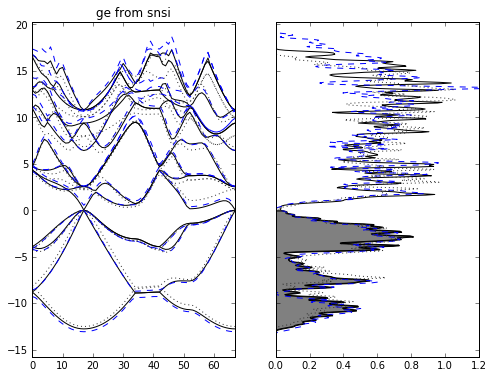

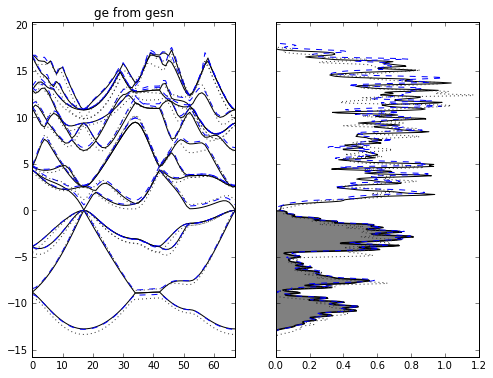

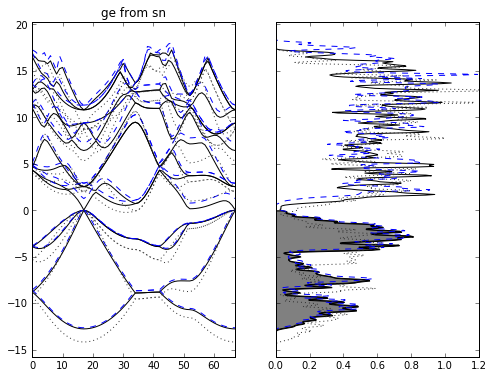

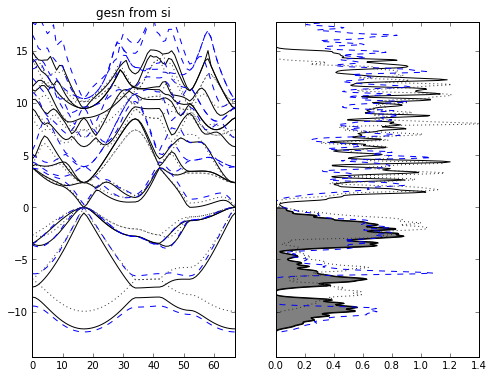

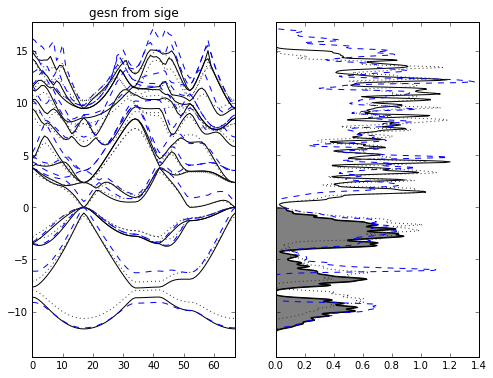

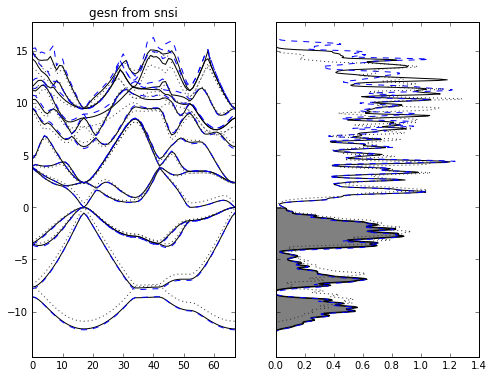

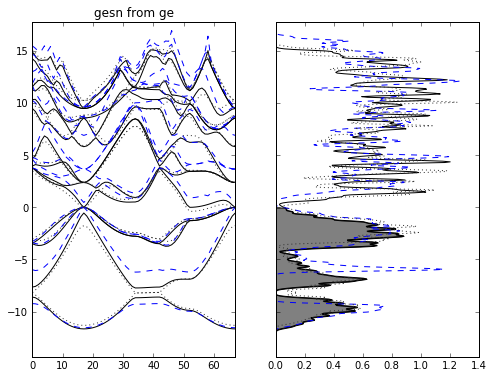

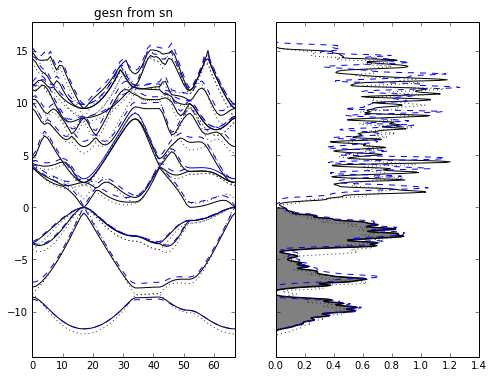

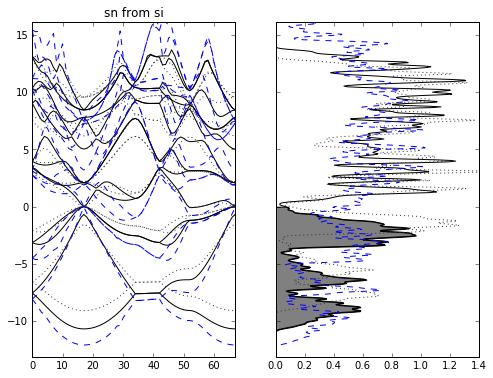

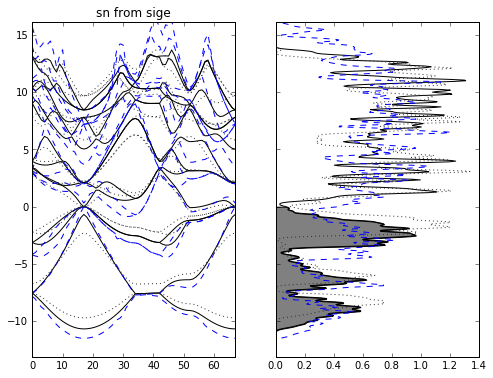

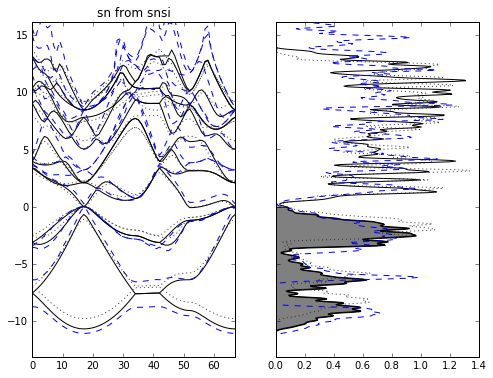

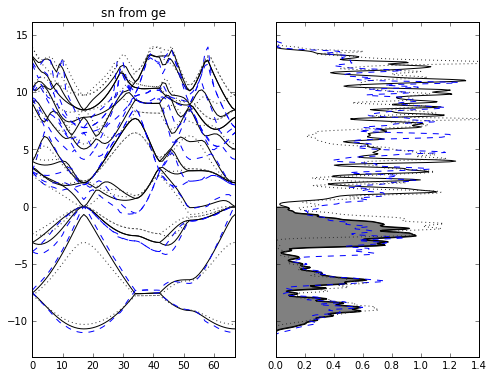

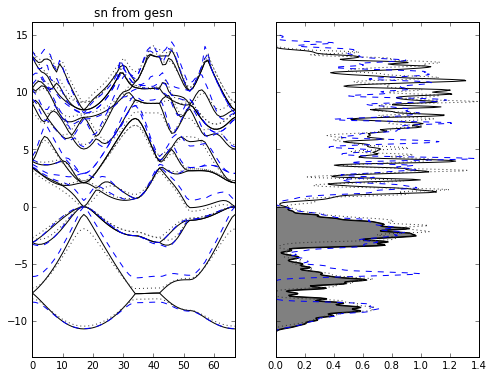

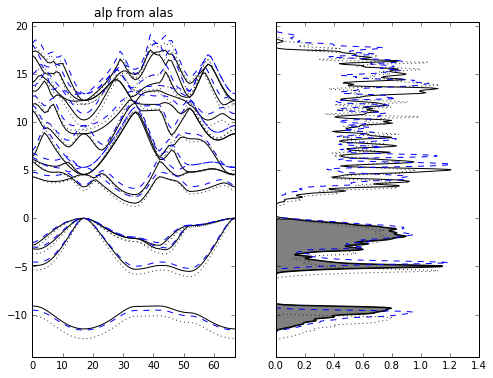

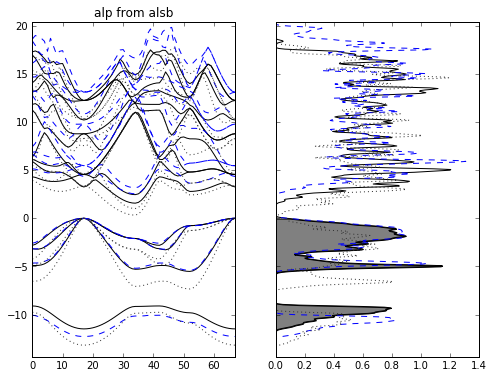

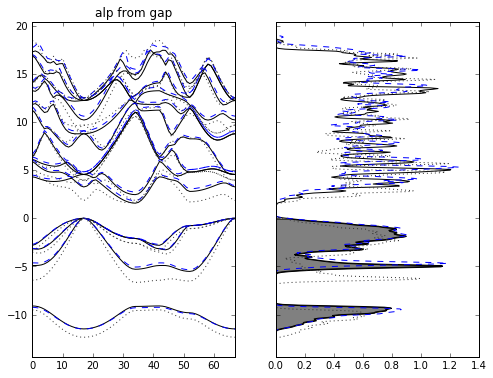

In [18]:
# plot every system!

#p_max = 100000
p_min = 20
p_max = 40
itr = 1

for grp in cyl_grp:
    for sys in grp:
        for rsys in grp:
            if itr <= p_max and itr > p_min:
                if sys != rsys:
                    try:
                        #a_plot(sys, rsys, scan=False, save_path='fig')
                        a_plot(sys, rsys, scan=False, show_ref=True)
                    except Exception as err:
                        print "%s from %s failed with error: %s" % (sys, rsys, err)
            itr += 1

0.785636145507
['si_r-sige', 'si_r-ge', 'sige_r-si', 'sige_r-ge', 'snsi_r-gesn', 'ge_r-si', 'ge_r-sige', 'gesn_r-snsi', 'alp_r-gap', 'alp_r-inp', 'alas_r-gaas', 'alas_r-inas', 'alsb_r-gasb', 'alsb_r-insb', 'gap_r-alp', 'gaas_r-alas', 'gasb_r-alsb', 'inp_r-alp', 'inas_r-alas', 'insb_r-alsb']
si_r-sige 0.146059358153 0.0549670201866
si_r-ge 0.273157759901 0.0440824617338
sige_r-si 0.146059358153 0.00435382338112
sige_r-ge 0.144873211069 0.121090712787
snsi_r-gesn 0.147233932447 -0.0345584730876
ge_r-si 0.273157759901 0.0013605698066
ge_r-sige 0.144873211069 0.00081634188396
gesn_r-snsi 0.147233932447 0.00108845584528
alp_r-gap 0.458065236975 0.141771373848
alp_r-inp 0.34214371928 0.00217691169056
alas_r-gaas 0.462051343117 -0.0190479772924
alas_r-inas 0.351908792549 -0.0364632708169
alsb_r-gasb 0.464784469847 0.276739898662
alsb_r-insb 0.39216159595 0.33606074223
gap_r-alp 0.458065236975 0.359734656865
gaas_r-alas 0.462051343117 -0.151295362494
gasb_r-alsb 0.464784469847 0.329530007159
i

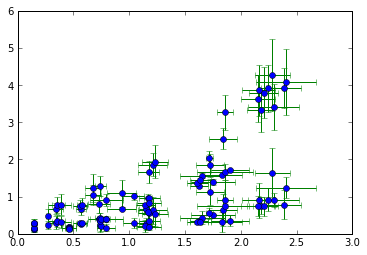

In [19]:
print max(_y_mean_good)
print good_list
plt.errorbar(q_mean, y_mean, yerr=y_ptp, xerr=q_ptp, ls='', marker='o', ecolor='g')
for i in range(len(good_list)):
    print good_list[i], good_list_q[i], good_list_Eg[i][1] - good_list_Eg[i][0]

<Container object of 3 artists>

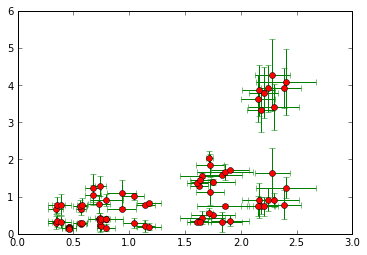

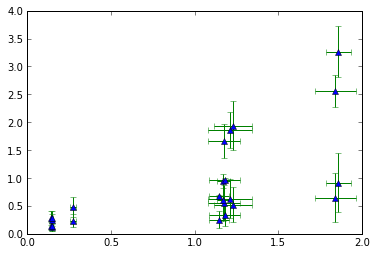

In [20]:
plt.figure()
plt.errorbar(q_diff_III_V_mean, y_maes_III_V_mean, yerr=y_maes_III_V_ptp, xerr=q_diff_III_V_ptp, ls='',color='r', marker='o', ecolor='g')
plt.figure()
plt.errorbar(q_diff_IV_IV_mean, y_maes_IV_IV_mean, yerr=y_maes_IV_IV_ptp, xerr=q_diff_IV_IV_ptp, ls='', marker='^', ecolor='g')

0.92878616935 0.0467842507379 0.0363739920698 0.930468126405 0.0192317324375


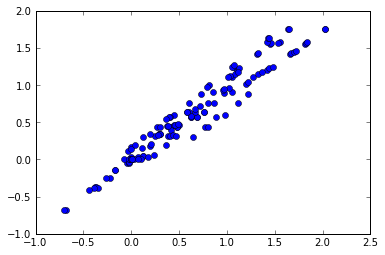

In [21]:
plt.plot(Eg_prd_all, Eg_ref_all, ls='', marker='o')
fitted = qtk.ML.l2_fit(Eg_prd_all, Eg_ref_all)
R2, rmse, mae = qtk.ML.error_measure(Eg_prd_all, fitted)
a, b = np.polyfit(Eg_prd_all, Eg_ref_all, 1)
print R2, rmse, mae, a, b

[0.62069194577092013, 0.62150828765488075, 0.80191984401004035, 0.47728788815527956, 0.00027211396132020838, -0.045170917579120395, 0.68708775233299946, 0.6881762081782794, 0.86260125738440063, 0.49579163752504041, 0.0016326837679203621, -0.021497002944279586]
[0.56572492558428156, 0.56708549539087905, 0.75783738227620034, 0.46558698781851948, 0.00027211396132020838, -0.049524740960239733, 0.56572492558428156, 0.56708549539087905, 0.75783738227620034, 0.46558698781851948, 0.00027211396132020838, -0.049524740960239733]


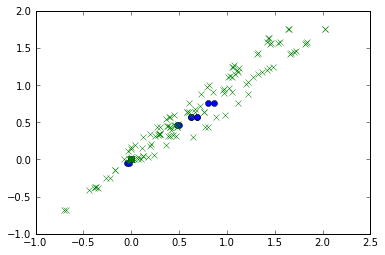

In [22]:
print Eg_prd_IV_IV_all
print Eg_ref_IV_IV_all
plt.plot(Eg_prd_IV_IV_all, Eg_ref_IV_IV_all, ls='', marker='o')
plt.plot(Eg_prd_III_V_all, Eg_ref_III_V_all, ls='', marker='x')

# Final plot

In [23]:
k_path = [17, 17, 8, 10, 15]

tick_pos = [0]
for k in k_path:
    tick_pos.append(tick_pos[-1] + k)
tick_txt = [
    r'$\mathrm{W}$', 
    r'$\mathrm{\Gamma}$', 
    r'$\mathrm{X}$', 
    r'$\mathrm{L}$', 
    r'$\mathrm{W}$', 
    r'$\mathrm{\Gamma}$',
]

/home/samio/local/miniconda2/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-linux-x86_64.egg/matplotlib/axes/_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/samio/local/miniconda2/lib/python2.7/site-packages/matplotlib-2.0.0-py2.7-linux-x86_64.egg/matplotlib/axes/_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


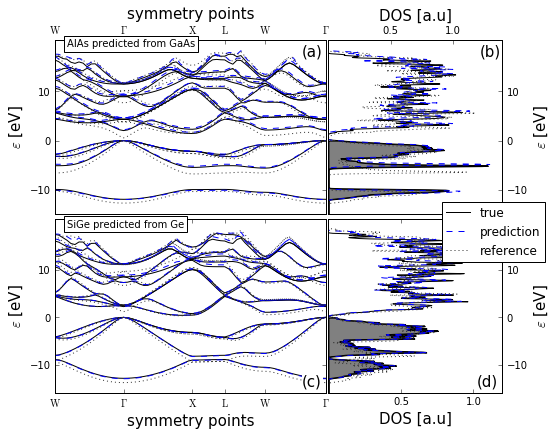

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(8,6))
#ax1.plot([1,2], [1,2])
#ax2.plot(1, 1, marker='x')
#ax3.plot(1, 1, marker='o')

def bandPlot(tar, ref, ax1, ax2):
    tru_Eg, tru_DOS, prd_Eg, prd_DOS = get(tar, ref, tar)
    ref_Eg, ref_DOS, _, _ = get(ref, ref, tar)
    plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS, ax1=ax1, ax2=ax2)
    
    ax1.set_xticks(tick_pos)
    ax1.set_xticklabels(tick_txt)
    ax1.set_xlabel('symmetry points', fontsize=15)
    
    ax2.set_xlabel('DOS [a.u]', fontsize=15)
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.set_xticks([0.5, 1])
    y2_min, y2_max = ax2.get_ylim()
    x2_min, x2_max = ax2.get_xlim()
    dy2 = y2_max - y2_min
    dx2 = x2_max - x2_min
    ax2.set_aspect(dx2/dy2)
    
    for ax in [ax1, ax2]:
        ax.set_yticks([-10, 0, 10])
        ax.set_ylabel(r'$\varepsilon$ [eV]', fontsize=15)
    

# tru_Eg, tru_DOS, prd_Eg, prd_DOS = get('sige', 'ge', 'sige')
# ref_Eg, ref_DOS, _, _ = get('ge', 'ge', 'sige')
# plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS, ax1=ax3, ax2=ax4)

bandPlot('alas', 'gaas', ax1, ax2)
bandPlot('sige', 'ge', ax3, ax4)


ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
for ax in [ax1, ax2]:
    ax.xaxis.set_label_position('top')




#ax3.errorbar(q_mean, y_mean, yerr=y_ptp, xerr=q_ptp, ls='', color='b', marker='o', ecolor='g')
# ax3.errorbar(
#     q_diff_III_V_mean, y_maes_III_V_mean, 
#     yerr=y_maes_III_V_ptp, xerr=q_diff_III_V_ptp, 
#     ls='', color='b', marker='^', ecolor='b')
# ax3.errorbar(
#     q_diff_IV_IV_mean, y_maes_IV_IV_mean, 
#     yerr=y_maes_IV_IV_ptp, xerr=q_diff_IV_IV_ptp, 
#     ls='', color='g', marker='v', ecolor='g')

# e_min = min(list(qtk.flatten([Eg_prd_all, Eg_ref_all])))
# e_max = max(list(qtk.flatten([Eg_prd_all, Eg_ref_all])))
# p4_min = e_min - 0.1 * (e_max - e_min)
# p4_max = e_max + 0.1 * (e_max - e_min)
# ax4.plot([p4_min, p4_max], [p4_min, p4_max], ls='--', color='k', lw=2)
# _x = np.linspace(0,3)
# #ax3.fill_between(_x, 0.5, 3,  facecolor='green', alpha=0.5, transform=trans)
# ax3.axvspan(0.5, 3, alpha=0.5, facecolor='gray')
# ax3.set_yticks([1, 3, 5])
# ax3.set_ylabel('averaged MAE [eV]', fontsize=15)
# ax3.yaxis.set_label_coords(-0.11, 0.5)
# ax3.set_xlabel(r'$\int\ d\mathbf{r} |\Delta\rho(\mathbf{r})|$ [a.u.]', fontsize=15)
# ax3.set_xticks([0,1,2,3])

# ax4.yaxis.tick_right()
# ax4.set_ylim(p4_min, p4_max)
# ax4.set_xlim(p4_min, p4_max)
# ax4.set_aspect('equal')
# ax4.set_yticks([0, 1, 2])
# ax4.set_xticks([0, 1, 2])
# ax4.set_xlabel(r'$E_g^{pred}$ [eV]', fontsize=15)
# ax4.set_ylabel(r'$E_g^{true}$ [eV]', fontsize=15)
# ax4.yaxis.set_label_coords(1.185, 0.5)
# ax4.xaxis.set_label_coords(0.5, -0.18)
# ax4.yaxis.set_label_position('right')

# ax4.plot([10,20], [10,20], color='k', label='AlAs')
# ax4.plot([20,30], [10,20], ls='--', color='b', label='prediction')
# ax4.plot([20,30], [10,20], ls=':', color='0.2', label='GaAs')
# ax4.plot(Eg_prd_III_V_all, Eg_ref_III_V_all, ls='', marker='^', color='b', label="III-V crystals")
# ax4.plot(Eg_prd_IV_IV_all, Eg_ref_IV_IV_all, ls='', marker='v', color='g', label='IV-IV crystals')

ax4.plot([10,20], [10,20], color='k', label='true')
ax4.plot([20,30], [10,20], ls='--', color='b', label='prediction')
ax4.plot([20,30], [10,20], ls=':', color='0.2', label='reference')

ax4.legend(loc=(0.65,0.75), numpoints=1)

ax1.text(3, 19, 
         'AlAs predicted from GaAs',
         bbox={'facecolor':'white', 'pad':3})
ax3.text(3, 19, 
         'SiGe predicted from Ge',
         bbox={'facecolor':'white', 'pad':3})
# ax2.text(-0.8, 17, 
#          'AlAs bandstructure/DOS predicted from GaAs',
#          bbox={'facecolor':'white', 'alpha':0.9, 'pad':10})

ax1.annotate('(a)', xytext=(61, 17), xy=(0,0), bbox=dict(fc="w",ec="w", pad=0), fontsize=15)
ax2.annotate('(b)', xytext=(1.22, 17), xy=(0,0), bbox=dict(fc="w",ec="w", pad=0), fontsize=15)
ax3.annotate('(c)', xytext=(61, -14.5), xy=(0,0), bbox=dict(fc="w",ec="w", pad=0), fontsize=15)
ax4.annotate('(d)', xytext=(1.02, -14.5), xy=(0,0), bbox=dict(fc="w",ec="w", pad=0), fontsize=15)

plt.tight_layout(0.5)
fig.subplots_adjust(wspace=-0.17)
plt.savefig('Eg_summary.pdf')

(0.9195127047188566, 0.62623438412692078, 0.50693790161070329)
[ 0.98253162  0.00612574]
1.67132395043
1.41798585244
0.395653699759
0.544500036601


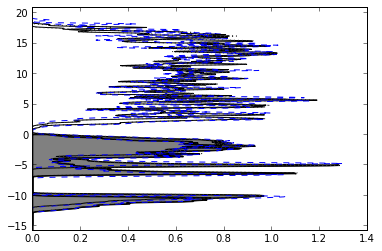

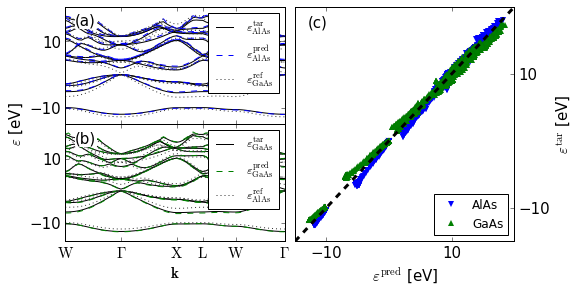

In [29]:
def bandPlot2(tar, ref, ax1, ax2, true_label='', ref_label='', prd_label='', prd_color='b'):
    tru_Eg, tru_DOS, prd_Eg, prd_DOS = get(tar, ref, tar)
    ref_Eg, ref_DOS, _, _ = get(ref, ref, tar)
    _, _, band_ref, band_prd = plot_band(
        tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS, ax1=ax1, ax2=ax2,return_band=True,
        true_label=true_label, ref_label=ref_label, prd_label=prd_label, prd_color=prd_color,
    )
    return band_ref, band_prd

fig, ax_tmp = plt.subplots(1)

fig = plt.figure(figsize=(8,4))

gs0 = gridspec.GridSpec(1, 2)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])
ax3 = fig.add_subplot(gs2[0, 0])

bnd_alas_ref_np, bnd_alas_prd_np = bandPlot2('alas', 'gaas', ax1, ax_tmp, 
                                       r'$\varepsilon_{\rm AlAs}^{\rm tar}$', 
                                       r'$\varepsilon_{\rm GaAs}^{\rm ref}$', 
                                       r'$\varepsilon_{\rm AlAs}^{\rm pred}$')
bnd_sige_ref_np, bnd_sige_prd_np = bandPlot2('gaas', 'alas', ax2, ax_tmp, 
                                       r'$\varepsilon_{\rm GaAs}^{\rm tar}$', 
                                       r'$\varepsilon_{\rm AlAs}^{\rm ref}$', 
                                       r'$\varepsilon_{\rm GaAs}^{\rm pred}$','g')
bnd_alas_ref = list(qtk.flatten([bnd_alas_ref_np.tolist()]))
bnd_alas_prd = list(qtk.flatten([bnd_alas_prd_np.tolist()]))
bnd_sige_ref = list(qtk.flatten([bnd_sige_ref_np.tolist()]))
bnd_sige_prd = list(qtk.flatten([bnd_sige_prd_np.tolist()]))
ax3.plot(bnd_alas_prd, bnd_alas_ref, color='b', marker='v', ls='', label='AlAs', mew=.01)
ax3.plot(bnd_sige_prd, bnd_sige_ref, color='g', marker='^', ls='', label='GaAs', mew=.01)
bnd_prd = list(qtk.flatten([bnd_alas_prd, bnd_sige_prd]))
bnd_ref = list(qtk.flatten([bnd_alas_ref, bnd_sige_ref]))
bnd_fit = qtk.ML.l2_fit(bnd_prd, bnd_ref)
# print bnd_prd
# print bnd_ref
print qtk.ML.error_measure(bnd_ref, bnd_fit)
print np.polyfit(bnd_prd, bnd_ref, 1)
print np.min(np.array(bnd_alas_prd)[np.array(bnd_alas_prd) > 0])
print np.min(np.array(bnd_sige_ref)[np.array(bnd_sige_ref) > 0])
print np.min(np.array(bnd_sige_prd)[np.array(bnd_sige_prd) > 0])
print np.min(np.array(bnd_alas_ref)[np.array(bnd_alas_ref) > 0])

ax3.yaxis.set_label_position('right')
ax3.yaxis.tick_right()
ax3.legend(numpoints=1, loc=4)
ax3.yaxis.set_ticks([-10, 10])
ax3.xaxis.set_ticks([-10, 10])
ax3.tick_params(labelsize=15)
smin, smax = ax3.get_ylim()
ax3.set_xlim(smin, smax)
ax3.plot([smin, smax], [smin, smax], ls='--', color='k', lw=3)
ax3.set_xlabel(r'$\varepsilon^{\rm pred}$ [eV]', fontsize=15)
ax3.set_ylabel(r'$\varepsilon^{\rm tar}$ [eV]', fontsize=15)

def setbnd(ax, x_label=True):
    ax.set_xticks(tick_pos)
    ax.legend()
    ax.yaxis.set_ticks([-10, 10])
    ax.tick_params(labelsize=15)
    if x_label:
        ax.set_xticklabels(tick_txt, fontsize=15)
    else:
        ax.set_xticklabels(['' for _ in tick_txt])
setbnd(ax1, False)
setbnd(ax2)
ax2.set_ylabel(r'$\varepsilon$ [eV]', y=1, fontsize=15)
ax2.set_xlabel(r'$\mathbf{k}$', fontsize=15)

ax1.text(3,15,'(a)', bbox=dict(fc="w",ec="w", pad=0), fontsize=15)
ax2.text(3,15,'(b)', bbox=dict(fc="w",ec="w", pad=0), fontsize=15)
ax3.text(-13,17,'(c)', bbox=dict(fc="w",ec="w", pad=0), fontsize=15)

plt.tight_layout(0.5)
fig.subplots_adjust(hspace=0)
plt.savefig('Eg_summary.pdf')

0.141227145925
0.253338097989
0.0876717169128
-0.148846336842
-0.20408547099
0.127800522856
0.107736119884


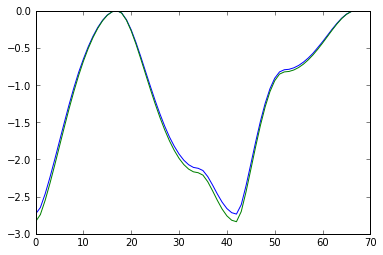

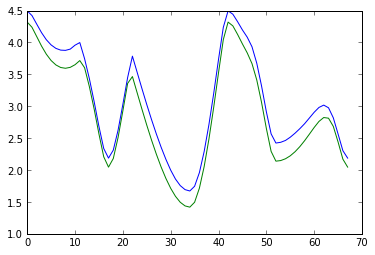

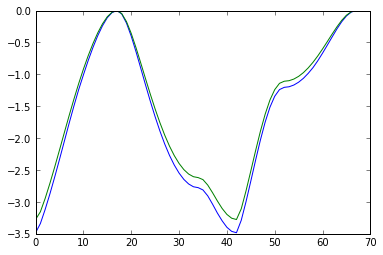

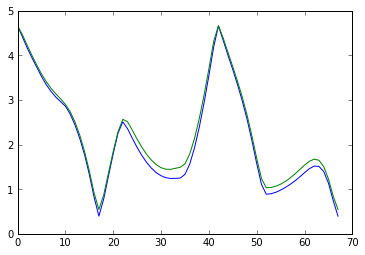

In [50]:
plt.plot(bnd_alas_prd_np[:,3])
plt.plot(bnd_sige_ref_np[:,3])
plt.figure()
plt.plot(bnd_alas_prd_np[:,4])
plt.plot(bnd_sige_ref_np[:,4])
plt.figure()
plt.plot(bnd_sige_prd_np[:,3])
plt.plot(bnd_alas_ref_np[:,3])
plt.figure()
plt.plot(bnd_sige_prd_np[:,4])
plt.plot(bnd_alas_ref_np[:,4])
print np.min(bnd_alas_prd_np[:20,4]) - np.min(bnd_sige_ref_np[:20,4])
print np.min(bnd_alas_prd_np[20:,4]) - np.min(bnd_sige_ref_np[20:,4])
mae_alas = abs(bnd_alas_prd_np[:,:4] - bnd_sige_ref_np[:,:4]).mean()
print mae_alas
print np.min(bnd_sige_prd_np[:20,4]) - np.min(bnd_alas_ref_np[:20,4])
print np.min(bnd_sige_prd_np[20:40,4]) - np.min(bnd_alas_ref_np[20:40,4])
mae_sige = abs(bnd_sige_prd_np[:,:4] - bnd_alas_ref_np[:,:4]).mean()
print mae_sige
print (mae_alas + mae_sige)/2

In [26]:
type(bnd_alas_prd)

list

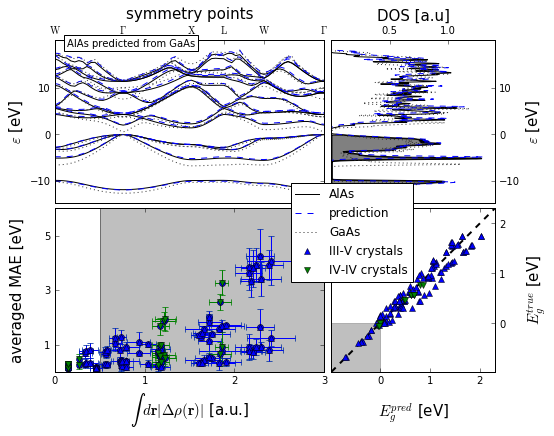

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(8,6))
#ax1.plot([1,2], [1,2])
#ax2.plot(1, 1, marker='x')
#ax3.plot(1, 1, marker='o')

def bandPlot(tar, ref, ax1, ax2):
    tru_Eg, tru_DOS, prd_Eg, prd_DOS = get(tar, ref, tar)
    ref_Eg, ref_DOS, _, _ = get(ref, ref, tar)
    plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS, ax1=ax1, ax2=ax2)
    
    ax1.set_xticks(tick_pos)
    ax1.set_xticklabels(tick_txt)
    ax1.set_xlabel('symmetry points', fontsize=15)
    
    ax2.set_xlabel('DOS [a.u]', fontsize=15)
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax2.set_xticks([0.5, 1])
    y2_min, y2_max = ax2.get_ylim()
    x2_min, x2_max = ax2.get_xlim()
    dy2 = y2_max - y2_min
    dx2 = x2_max - x2_min
    ax2.set_aspect(dx2/dy2)
    
    for ax in [ax1, ax2]:
        ax.set_yticks([-10, 0, 10])
        ax.set_ylabel(r'$\varepsilon$ [eV]', fontsize=15)
    

# tru_Eg, tru_DOS, prd_Eg, prd_DOS = get('sige', 'ge', 'sige')
# ref_Eg, ref_DOS, _, _ = get('ge', 'ge', 'sige')
# plot_band(tru_Eg, tru_DOS, prd_Eg, prd_DOS, ref_Eg, ref_DOS, ax1=ax3, ax2=ax4)

bandPlot('alas', 'gaas', ax1, ax2)
#bandPlot('sige', 'ge', ax3, ax4)


ax1.xaxis.tick_top()
ax2.xaxis.tick_top()
for ax in [ax1, ax2]:
    ax.xaxis.set_label_position('top')




ax3.errorbar(q_mean, y_mean, yerr=y_ptp, xerr=q_ptp, ls='', color='b', marker='o', ecolor='g')
ax3.errorbar(
    q_diff_III_V_mean, y_maes_III_V_mean, 
    yerr=y_maes_III_V_ptp, xerr=q_diff_III_V_ptp, 
    ls='', color='b', marker='^', ecolor='b')
ax3.errorbar(
    q_diff_IV_IV_mean, y_maes_IV_IV_mean, 
    yerr=y_maes_IV_IV_ptp, xerr=q_diff_IV_IV_ptp, 
    ls='', color='g', marker='v', ecolor='g')

e_min = min(list(qtk.flatten([Eg_prd_all, Eg_ref_all])))
e_max = max(list(qtk.flatten([Eg_prd_all, Eg_ref_all])))
p4_min = e_min - 0.1 * (e_max - e_min)
p4_max = e_max + 0.1 * (e_max - e_min)
ax4.plot([p4_min, p4_max], [p4_min, p4_max], ls='--', color='k', lw=2)
_x = np.linspace(0,3)
#ax3.fill_between(_x, 0.5, 3,  facecolor='green', alpha=0.5, transform=trans)
ax3.axvspan(0.5, 3, alpha=0.5, facecolor='gray')
ax3.set_yticks([1, 3, 5])
ax3.set_ylabel('averaged MAE [eV]', fontsize=15)
ax3.yaxis.set_label_coords(-0.11, 0.5)
ax3.set_xlabel(r'$\int\ d\mathbf{r} |\Delta\rho(\mathbf{r})|$ [a.u.]', fontsize=15)
ax3.set_xticks([0,1,2,3])

ax4.yaxis.tick_right()
ax4.set_ylim(p4_min, p4_max)
ax4.set_xlim(p4_min, p4_max)
ax4.set_aspect('equal')
ax4.set_yticks([0, 1, 2])
ax4.set_xticks([0, 1, 2])
ax4.set_xlabel(r'$E_g^{pred}$ [eV]', fontsize=15)
ax4.set_ylabel(r'$E_g^{true}$ [eV]', fontsize=15)
ax4.yaxis.set_label_coords(1.185, 0.5)
ax4.xaxis.set_label_coords(0.5, -0.18)
ax4.yaxis.set_label_position('right')

ax4.plot([10,20], [10,20], color='k', label='AlAs')
ax4.plot([20,30], [10,20], ls='--', color='b', label='prediction')
ax4.plot([20,30], [10,20], ls=':', color='0.2', label='GaAs')
ax4.plot(Eg_prd_III_V_all, Eg_ref_III_V_all, ls='', marker='^', color='b', label="III-V crystals")
ax4.plot(Eg_prd_IV_IV_all, Eg_ref_IV_IV_all, ls='', marker='v', color='g', label='IV-IV crystals')

# ax4.plot([10,20], [10,20], color='k', label='true')
# ax4.plot([20,30], [10,20], ls='--', color='b', label='prediction')
# ax4.plot([20,30], [10,20], ls=':', color='0.2', label='reference')

ax4.axvspan(-1, 0, ymin=0, ymax=((0-p4_min) / (p4_max - p4_min)), alpha=0.5, color='gray')
ax4.legend(loc=(-0.25,0.55), numpoints=1)

ax1.text(3, 19, 
         'AlAs predicted from GaAs',
         bbox={'facecolor':'white', 'pad':3})
# ax3.text(3, 19, 
#          'SiGe predicted from Ge',
#          bbox={'facecolor':'white', 'pad':3})
# ax2.text(-0.8, 17, 
#          'AlAs bandstructure/DOS predicted from GaAs',
#          bbox={'facecolor':'white', 'alpha':0.9, 'pad':10})

plt.tight_layout(0.5)
fig.subplots_adjust(wspace=-0.17)
plt.savefig('Eg_summary_old.pdf')

# Heatmap

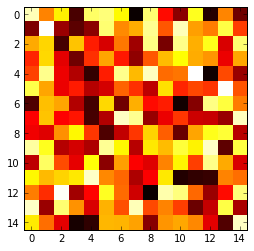

In [24]:
a = np.random.random([15,15])
plt.imshow(a, cmap='hot', interpolation='nearest')

## get error matrix

In [25]:
III_list = ['Al', 'Ga', 'In']
V_list = ['P', 'As', 'Sb']
IV_list = ['Si', 'Ge', 'Sn']

III_V = []
for b in V_list:
    for a in III_list:
        III_V.append(a+b)
        
IV = []
for i in range(len(IV_list)):
    a = IV_list[i]
    for j in range(len(IV_list)):
        b = IV_list[j]
        if i < j:
            cyl1 = a + b
            cyl2 = b + a
        elif i > j:
            cyl1 = b + a
            cyl2 = a + b
        else:
            cyl1 = cyl2 = a
        out = get(cyl1.lower())[0]
        if out is None:
            cyl = cyl2
        else:
            cyl = cyl1
        if cyl not in IV:
            IV.append(cyl)
print III_V
print IV

sisn_a-sisn not found
sisn_a-sisn not found
['AlP', 'GaP', 'InP', 'AlAs', 'GaAs', 'InAs', 'AlSb', 'GaSb', 'InSb']
['Si', 'SiGe', 'SnSi', 'Ge', 'GeSn', 'Sn']


In [26]:
for cyl in IV:
    print get(cyl)

Si_a-Si not found
(None, None, None, None)
SiGe_a-SiGe not found
(None, None, None, None)
SnSi_a-SnSi not found
(None, None, None, None)
Ge_a-Ge not found
(None, None, None, None)
GeSn_a-GeSn not found
(None, None, None, None)
Sn_a-Sn not found
(None, None, None, None)


In [27]:
def get_err_matrix(cyl_names, good_level=0.2):
    err_III_V = []
    good_x = []
    good_y = []
    N = len(cyl_names)
    for i in range(N):
        prd_sys = cyl_names[i]
        prd_list = []
        err_III_V.append(prd_list)
        for j in range(N):
           
            ref_sys = cyl_names[j]
            entry_err_list = []
            for a_sys in cyl_names:
                outs = get(prd_sys.lower(), ref_sys.lower(), a_sys.lower())
                ref_DOS, prd_DOS = outs[1], outs[3]
                integrand = np.abs(ref_DOS.band - prd_DOS.band)
                entry_err_list.append(ref_DOS.BZ_integrate(integrand).mean())
            mean_err = np.mean(entry_err_list)
            print "%-4s %-4s %f" % (prd_sys, ref_sys, mean_err),
            if mean_err < good_level and i != j:
                good_x.append(i)
                good_y.append(j)
                print 'good!'
            else:
                print
            prd_list.append(mean_err)
    return np.asarray(err_III_V), good_x, good_y

err_III_V, good_III_V_x, good_III_V_y = get_err_matrix(III_V)
err_IV, good_IV_x, good_IV_y = get_err_matrix(IV)

AlP  AlP  0.050898
AlP  GaP  0.153081 good!
AlP  InP  0.303341
AlP  AlAs 0.266740
AlP  GaAs 0.404851
AlP  InAs 0.438078
AlP  AlSb 0.755844
AlP  GaSb 0.911371
AlP  InSb 0.910774
GaP  AlP  0.156875 good!
GaP  GaP  0.058190
GaP  InP  0.243571
GaP  AlAs 0.395104
GaP  GaAs 0.282283
GaP  InAs 0.289051
GaP  AlSb 0.904484
GaP  GaSb 0.751993
GaP  InSb 0.783982
InP  AlP  0.675983
InP  GaP  0.343167
InP  InP  0.046273
InP  AlAs 1.040399
InP  GaAs 0.675076
InP  InAs 0.289780
InP  AlSb 1.645526
InP  GaSb 1.237541
InP  InSb 0.739543
AlAs AlP  0.671014
AlAs GaP  0.911842
AlAs InP  1.224771
AlAs AlAs 0.025835
AlAs GaAs 0.187853 good!
AlAs InAs 0.334979
AlAs AlSb 0.355275
AlAs GaSb 0.517455
AlAs InSb 0.546080
GaAs AlP  0.791090
GaAs GaP  0.741057
GaAs InP  1.093380
GaAs AlAs 0.155769 good!
GaAs GaAs 0.030602
GaAs InAs 0.214047
GaAs AlSb 0.434443
GaAs GaSb 0.308403
GaAs InSb 0.350100
InAs AlP  1.283831
InAs GaP  1.011952
InAs InP  0.787042
InAs AlAs 0.771283
InAs GaAs 0.390352
InAs InAs 0.032089
InAs Al

['alp', 'gap', 'inp', 'alas', 'gaas', 'inas', 'alsb', 'gasb', 'insb']
['si', 'sige', 'snsi', 'ge', 'gesn', 'sn']


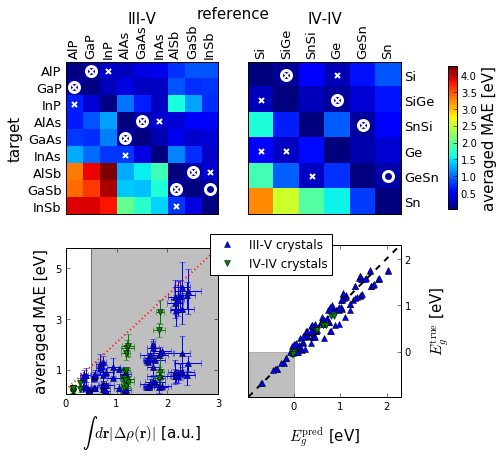

In [28]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(6,6))

vmin = min(np.min(err_III_V), np.min(err_IV))
vmax = max(np.max(err_III_V), np.max(err_IV))

data1 = err_III_V
data2 = err_IV

im = ax1.imshow(data1, interpolation='nearest', vmin=vmin, vmax=vmax)
im = ax2.imshow(data2, interpolation='nearest', vmin=vmin, vmax=vmax)

def cyl_tick(cyl_list, ax):
    ax.set_xticks(range(len(cyl_list)))
    ax.set_xticklabels(cyl_list, fontsize=13)
    ax.set_yticks(range(len(cyl_list)))
    ax.set_yticklabels(cyl_list, fontsize=13)
    ax.xaxis.tick_top()
    plt.setp(ax.get_xticklabels(), rotation=90)

def remove_tick(ax):
    for tic in ax.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

cyl_tick(IV, ax2)
cyl_tick(III_V, ax1)
ax1.set_ylabel('target', fontsize=15)
ax1.set_xlabel('reference', fontsize=15, x=1.1)
ax1.xaxis.set_label_position('top')
#ax2.set_ylabel('target', fontsize=15)
#ax2.set_xlabel('reference', fontsize=15)
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax12 = fig.add_subplot()
#ax1.xaxis.set_label_coords(1.2, 1.2)
def highlight(ax, data):
    x, y = np.where((data < 0.2) * np.logical_not(np.eye(len(data))))
    ax.plot(y, x,
            ls='', marker='o', 
            markerfacecolor="None", markeredgecolor='w',
            mew=3, markersize=10)
    
def highlight_small_q_diff(ax, grp_list):
    ref_coord_cry = [c.lower() for c in grp_list]
    print ref_coord_cry
    x = []
    y = []
    for prd, ref in [g.split('_r-') for g in good_list]:
        if prd in ref_coord_cry:
            x.append(ref_coord_cry.index(ref))
            y.append(ref_coord_cry.index(prd))
    ax.plot(y, x,
            ls='', marker='x', 
            markerfacecolor="None", markeredgecolor='w',
            mew=2, markersize=5)
    
highlight(ax1, data1)
highlight(ax2, data2)
highlight_small_q_diff(ax1, III_V)
highlight_small_q_diff(ax2, IV)
remove_tick(ax1)
remove_tick(ax2)

#ax3.errorbar(q_mean, y_mean, yerr=y_ptp, xerr=q_ptp, ls='', color='b', marker='o', ecolor='g')
ax3.errorbar(
    q_diff_III_V_mean, y_maes_III_V_mean, 
    yerr=y_maes_III_V_ptp, xerr=q_diff_III_V_ptp, 
    ls='', color='b', marker='^', ecolor='b')
ax3.errorbar(
    q_diff_IV_IV_mean, y_maes_IV_IV_mean, 
    yerr=y_maes_IV_IV_ptp, xerr=q_diff_IV_IV_ptp, 
    ls='', color='g', marker='v', ecolor='g')
ax3.axvspan(0.5, 3, alpha=0.5, facecolor='gray')
ax3.set_yticks([1, 3, 5])
ax3.set_ylabel('averaged MAE [eV]', fontsize=15)
ax3.yaxis.set_label_coords(-0.11, 0.5)
ax3.set_xlabel(r'$\int\ d\mathbf{r} |\Delta\rho(\mathbf{r})|$ [a.u.]', fontsize=15)
ax3.set_xticks([0,1,2,3])
y3_lim = reduce(lambda x, y: y-x, ax3.get_ylim())
x3_lim = reduce(lambda x, y: y-x, ax3.get_xlim())
ax3.set_aspect(x3_lim / y3_lim)

e_min = min(list(qtk.flatten([Eg_prd_all, Eg_ref_all])))
e_max = max(list(qtk.flatten([Eg_prd_all, Eg_ref_all])))
p4_min = e_min - 0.1 * (e_max - e_min)
p4_max = e_max + 0.1 * (e_max - e_min)
ax4.plot([p4_min, p4_max], [p4_min, p4_max], ls='--', color='k', lw=2)
ax4.yaxis.tick_right()
ax4.set_ylim(p4_min, p4_max)
ax4.set_xlim(p4_min, p4_max)
ax4.set_aspect('equal')
ax4.set_yticks([0, 1, 2])
ax4.set_xticks([0, 1, 2])
ax4.set_xlabel(r'$E_g^{\mathrm{pred}}$ [eV]', fontsize=15)
ax4.set_ylabel(r'$E_g^{\mathrm{true}}$ [eV]', fontsize=15)
ax4.yaxis.set_label_coords(1.185, 0.5)
ax4.xaxis.set_label_coords(0.5, -0.18)
ax4.yaxis.set_label_position('right')
# ax4.plot([10,20], [10,20], color='k', label='AlAs')
# ax4.plot([20,30], [10,20], ls='--', color='b', label='prediction')
# ax4.plot([20,30], [10,20], ls=':', color='0.2', label='GaAs')
ax4.plot(Eg_prd_III_V_all, Eg_ref_III_V_all, ls='', marker='^', color='b', label="III-V crystals")
ax4.plot(Eg_prd_IV_IV_all, Eg_ref_IV_IV_all, ls='', marker='v', color='g', label='IV-IV crystals')

ax4.axvspan(-1, 0, ymin=0, ymax=((0-p4_min) / (p4_max - p4_min)), alpha=0.5, color='gray')
ax4.legend(loc=(-0.25,0.8), numpoints=1)

ax1.set_title("III-V", y=1.22, fontsize=15)
ax2.set_title("IV-IV", y=1.22, fontsize=15)

cax = fig.add_axes([1.01, 0.56, 0.02, 0.33])
cb = fig.colorbar(im, cax=cax)
cb.set_label(r'averaged MAE [eV]', fontsize=15)

ax3.plot([0,3], [0.2,5.8], color='r', ls = ':', lw=2)

#plt.tight_layout()
fig.savefig("Eg_heatmap.pdf", bbox_inches='tight')

In [29]:
print qtk.ML.error_measure(Eg_prd_all, Eg_ref_all)
print np.polyfit(Eg_prd_all, Eg_ref_all,1)

(0.81079146348094944, 0.13475332005404231, 0.096642319954956896)
[ 0.93046813  0.01923173]


0.799015449392 0.0968004124907


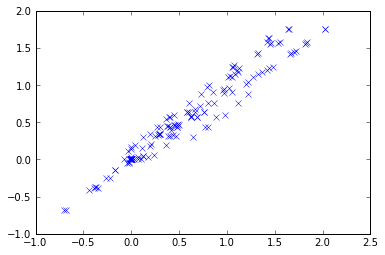

In [30]:
x_good_Eg = np.hstack([Eg_prd_III_V_all, Eg_prd_IV_IV_all])
y_good_Eg = np.hstack([Eg_ref_III_V_all, Eg_ref_IV_IV_all])
plt.plot(x_good_Eg, y_good_Eg, ls='', marker='x')
fitted_good = qtk.ML.l2_fit(x_good_Eg,y_good_Eg)
R_good, _, mae_good = qtk.ML.error_measure(y_good_Eg, fitted_good)
print R_good, mae_good

# Good list table

In [31]:
print [g.split('_r-') for g in good_list]
iii_v = [c.lower() for c in III_V]
iv = [c.lower() for c in IV]

[['si', 'sige'], ['si', 'ge'], ['sige', 'si'], ['sige', 'ge'], ['snsi', 'gesn'], ['ge', 'si'], ['ge', 'sige'], ['gesn', 'snsi'], ['alp', 'gap'], ['alp', 'inp'], ['alas', 'gaas'], ['alas', 'inas'], ['alsb', 'gasb'], ['alsb', 'insb'], ['gap', 'alp'], ['gaas', 'alas'], ['gasb', 'alsb'], ['inp', 'alp'], ['inas', 'alas'], ['insb', 'alsb']]


In [32]:
print len(good_list)

20


In [33]:
ls

analysis_back.ipynb  Eg_summary_old.pdf            prediction_scan_vary_a.py
analysis.ipynb       Eg_summary.pdf                q_diff.pkl
analysis_raw.ipynb   fig/                          qtk_Eg.ipynb
base.py              lattice_constants.ipynb       qtk_Eg_vary_a.ipynb
base.pyc             prd_bnd.pkl                   qtk_Eg_vary_a.py
cube/                prd_dos.pkl                   ref_bnd.pkl
cube.tar.gz          prediction_scan.ipynb         ref_dos.pkl
Eg_heatmap_2x2.pdf   prediction_scan.py            toLocal.tar.gz
Eg_heatmap.pdf       prediction_scan_vary_a.ipynb
